# Linear Regression

Linear Regression, though simple, is widely used for its interpretability and often surprising effectiveness. Given a dataset with an outcome $y$ and a single feature $x$, Linear Regression aims to model a linear relationship by finding parameters $\beta$ that minimize the distance (typically the squared error) between the true values and the predictions.

For example, if we want to predict height based on age, Linear Regression will provide $\beta$ such that :
$$
\text{Height} \approx \beta_0 + \beta_1 \cdot \text{Age}
$$
Is as close as possible (in the least-squares sense) to the observed heights in the dataset.

Now, we are making a Bayesian Linear Regression. This goes one step further : instead of giving just one value for $\beta$, **it gives a range of possible values based on what we already know and the data we have**. This way, we can see not **only a prediction, but also how confident we are about it**. 

In [1]:
# Source - https://stackoverflow.com/questions/55714135/how-can-i-fix-an-omp-error-15-initializing-libiomp5-dylib-but-found-libomp
# Posted by O.rka
# Retrieved 2025-11-06, License - CC BY-SA 4.0

import os
os.environ['MKL_THREADING_LAYER']='TBB'

In [2]:
# Imports
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr

## Generating Data

First, let's create a synthetic dataset representing 200 people with their age and height. To make sure our model recovers the true parameters, we generate heights as follows:

$$
\text{Height} = 76 + 5.5 \cdot \text{Age} + \epsilon
$$

With $\epsilon \sim \mathcal{N}(0, 10)$, some random noise. 

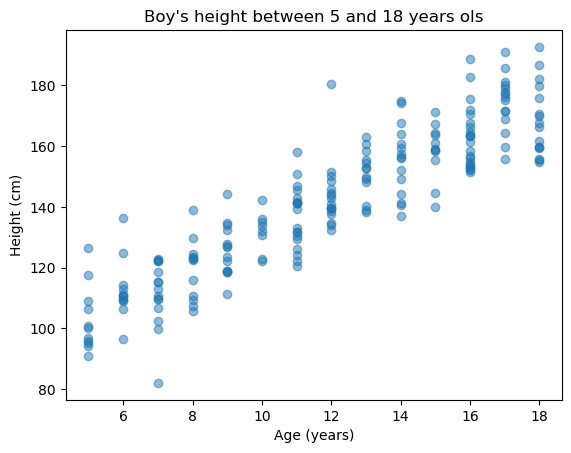

In [3]:
# Synthetic dataset ...

# True values
beta_1, beta_0 = 5.5, 76
sigma = 10

# Between 5 and 18 years old
np.random.seed(42)  # For reproductibility
x = np.random.randint(5, 19, size=200)

# Getting Heights
noise = np.random.normal(0, sigma, size=x.shape)  # Gaussian noise
y = beta_0 + beta_1 * x + noise

# Créer un DataFrame
data = pd.DataFrame({"age": x, "intercept": [1 for _ in range(len(x))], "height": y})

plt.scatter(data["age"], data["height"], alpha=0.5)
plt.ylabel("Height (cm)")
plt.xlabel("Age (years)")
plt.title("Boy's height between 5 and 18 years ols");

## Building a model

To use a Linear Regression model in PyBH is quite straightforward. You'll simply need to instantiate the LinearRegression model :

In [4]:
from PyBH.pymc_models import LinearRegression

my_linear_regression = LinearRegression()

You can use the model as is. Sometimes prior knowledge (expert judgment, historical data) motivates specifying priors; for now, this implementation does not expose custom priors.

Choosing priors is beyond the scope of this notebook. We use weakly informative priors instead, broad, realistic ranges that regularize the model without overpowering the data.

## Using the model

Before fitting the model, we need to reformat the data. It may look a bit verbose here, but `xarray` is preferred to plain NumPy in many cases. A key advantage is named dimensions, which make it clearer what each value represents.

**No worries**: helper functions in the experiments will handle this for you, so you can keep using pandas/Polars as usual.

In [5]:
coords={"coeffs": ["age", "intercept"], "obs_ind": np.arange(x.shape[0]), "treated_units": ["height"]}

X = xr.DataArray(
    data[["age", "intercept"]].values,
    dims=["obs_ind", "coeffs"],
    coords={"obs_ind": data.index, "coeffs": "age"},
)

y = xr.DataArray(
    data["height"].values[:, None],
    dims=["obs_ind", "treated_units"],
    coords={"obs_ind": data.index, "treated_units": ["height"]},
)

Now, we just need to fit the model with the data

In [6]:
idata = my_linear_regression.fit(X=X, y=y, coords=coords)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


## Visualizing the results

Now we can plot the estimated values of $\beta_0$, $\beta_1$, and $\sigma$ (the noise uncertainty).

### First, we correctly recover $\beta_0 \approx 76$:

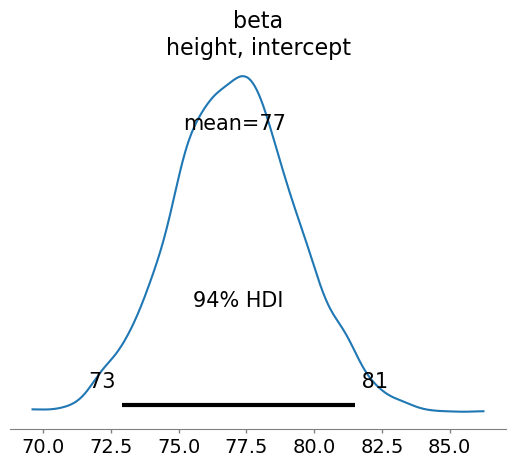

In [7]:
az.plot_posterior(
    idata,
    var_names=["beta"],
    coords={"treated_units": ["height"], "coeffs": ["intercept"]},
);

### Then, $\beta_1 \approx 5.5$ :

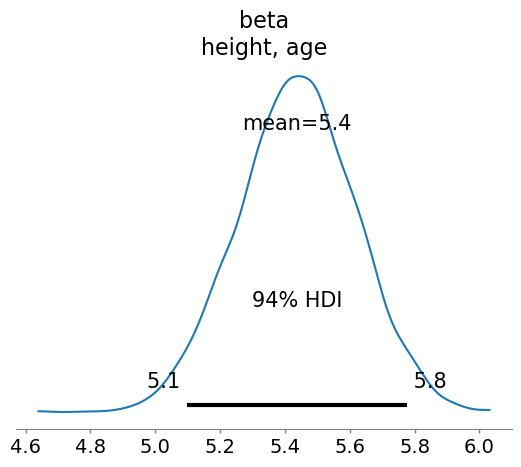

In [8]:
axes = az.plot_posterior(
    idata,
    var_names=["beta"],
    coords={"treated_units": ["height"], "coeffs": ["age"]},
);

### At last, we correctly get $\sigma \approx 10$ :

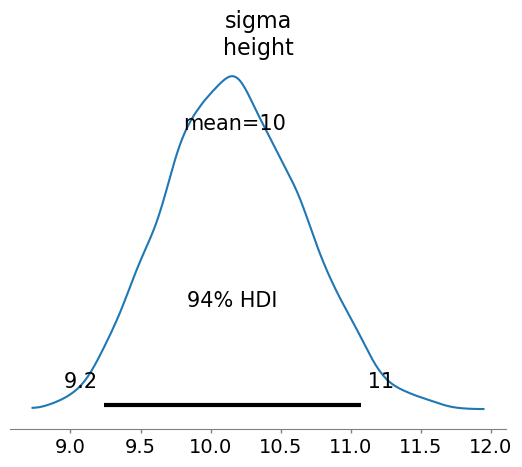

In [9]:
az.plot_posterior(
    idata,
    var_names=["sigma"],
    coords={"treated_units": ["height"], "coeffs": ["age"]},
);

### Visualizing predictions on the real data

To get a clearer idea, let's plot our predicted values along with their uncertainty over the real dataset:

Sampling: [y_hat]


c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\jeanv\AppData\Local\Temp\ipykernel_14272\1634532923.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_hdi = az.hdi(y_pred.T, hdi_prob=0.95)  # HDI = Highest Density Interval


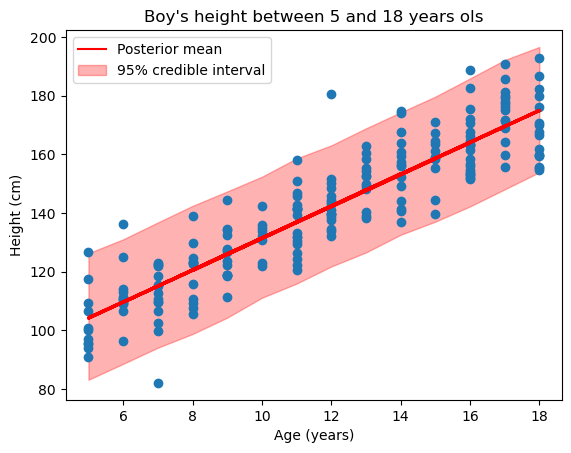

In [10]:
# Obtenir les prédictions postérieures (posterior predictive)
with my_linear_regression:
    post_pred = pm.sample_posterior_predictive(my_linear_regression.idata, var_names=["y_hat"], random_seed=42)

# Calculer l'intervalle crédible à 95%
y_pred = post_pred.posterior_predictive["y_hat"].stack(draws=("chain","draw")).values.squeeze()
y_mean = y_pred.mean(axis=1)
y_hdi = az.hdi(y_pred.T, hdi_prob=0.95)  # HDI = Highest Density Interval

# Tracer la moyenne et l'incertitude
plt.plot(x, y_mean, color='red', label='Posterior mean')
y_min = []
y_max = []
for i in np.arange(5, 19):
    y_min += [min(y_hdi[:,0][data["age"]==i])]
    y_max += [max(y_hdi[:,1][data["age"]==i])]
plt.fill_between(np.arange(5,19), y_min, y_max, color='red', alpha=0.3, label='95% credible interval')

plt.xlabel("Age")
plt.ylabel("Height")
plt.title("Bayesian Linear Regression with Uncertainty")
plt.legend()

plt.scatter(data["age"], data["height"])
plt.ylabel("Height (cm)")
plt.xlabel("Age (years)")
plt.title("Boy's height between 5 and 18 years ols");